# Оглавление

- [Введение](#introduction)
1. [Открытие и изучение данных](#opening_investigating)
2. [Предобработка данных](#preprocessing)
    - [Обработка пропусков](#processing)
    - [Замена типа данных](#type_replacement)
        1. [Обработка дубликатов](#duplicates)
        2. [Лемматизация](#lemmatization)
        3. [Категоризация данных](#categorization)
3. [Проверка гипотез](#hypothesis)
4. [Общий вывод](#conclusion)

<a id="introduction"></a>
# Исследование надёжности заёмщиков
## Описание проекта
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.
## План работы
Для достижения желаемого результата требуется открыть файл с данными и изучить информацию в нем, далее провести работу над предобработкой данных, и наконец проверить поставленные гипотезы, а именно:
- Существует зависимость между наличием детей и возвратом кредита в срок.
- Существует зависимость между семейным положением и возвратом кредита в срок.
- Существует зависимость между уровнем дохода и возвратом кредита в срок.
- Цели кредита по разному влияют на его возврат в срок.

## Результат работы
Результатом работы являются ответы на поставленные гипотезы, а также подробная выкладка по каждой из них.

# Шаг 1. Открытие и изучение данных
<a id="opening_investigating"></a>

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
from pymystem3 import Mystem

In [2]:
#читаем файл и выводим первые 5 строк и общую информацию
df = pd.read_csv('/datasets/data.csv')
display(df.tail())
display(df.describe())
df.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля
21524,2,-1984.507589,40,среднее,1,женат / замужем,0,F,сотрудник,0,82047.418899,на покупку автомобиля


,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

В столбцах `days_employed` и `total_income` содержатся пропущенные значения, также `days_employed` имеет тип `float`, хотя это трудовой стаж в днях. Посомтрев на первые 5 строк датафрейма можно заметить, что в `days_employed` содержатся отрицательные значения. Можно заметить что у `days_employed` и `total_income` равное количество пропусков. Благодаря методу info() можно заметить, что у кого-то 20 детей, но это все таки его выбор:)

# Шаг 2. Предобработка данных
<a id="preprocessing"></a>

## Обработка пропусков
<a id="processing"></a>

In [3]:
#проверяем связаны ли пропуски в трудовом стаже с другими столбцами
print('Совпадает ли количество пропущенных значений?',
      df[df['days_employed'].isnull()].shape[0] == df[df['total_income'].isnull()].shape[0])
df[df['days_employed'].isnull()].head()

Совпадает ли количество пропущенных значений? True


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


In [4]:
#заменим все строки с отрицательным количеством дней трудового стажа на модуль данного числа
df['days_employed'] = abs(df['days_employed']) 
#проверим результат
df[df['days_employed'] < 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
children            0 non-null int64
days_employed       0 non-null float64
dob_years           0 non-null int64
education           0 non-null object
education_id        0 non-null int64
family_status       0 non-null object
family_status_id    0 non-null int64
gender              0 non-null object
income_type         0 non-null object
debt                0 non-null int64
total_income        0 non-null float64
purpose             0 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 0.0+ bytes


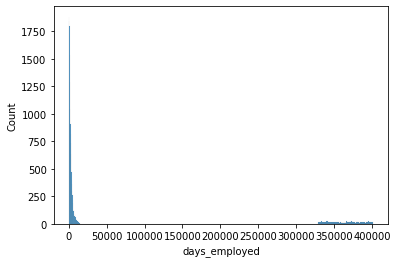

In [5]:
sns.histplot(data=df['days_employed'])

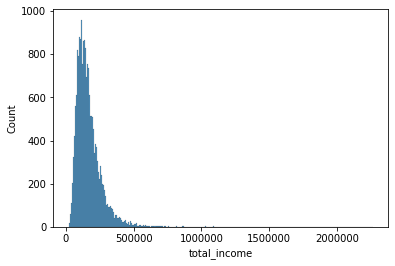

In [6]:
sns.histplot(data=df['total_income'])

**Выводы по графикам**
- days_employed имеет неравномерное распределение да и к тому же выбросы с неправдоподбными данными, которые следует удалить
- total_income распределен нормально, можно применить к нему метод mean()

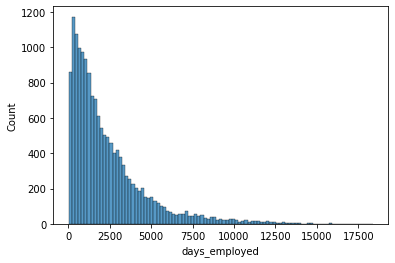

In [7]:
#Удалим значения в days_employed, превышающие 100000 и взглянем на график
df = df[df['days_employed'] < 100000]
sns.histplot(data=df['days_employed'])

In [8]:
#заполним пропуски в days_employed медианой, а в total_income средним арифметическим
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].median())
df['total_income'] = df['total_income'].fillna(df['total_income'].mean())
#проверим результат
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
5,0,926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья


На данном шаге:
* Заполнили пропуски в days_employed медианой
* Заполнили пропуски в total_income средним арифметическим

**Вывод**

Проверяя связь пропущенных значений с другими столбцами было установлено, что там где отсутствует `days_employed` отсутствует и `total_income`, также было замечено, что большинство значений в днях трудового стажа отрицательны и не было замечено никакой взаимосвязи ни с данным столбцом ни с другими, поэтому было принято решение заменить все отрицательные значения на их модуль. Были заменены все пропущенные значения в `days_employed` медианой, так как в данном столбце содержатся большие выбросы в большую сторону и среднее арифметическое показывает не самый лучший вариант. `total_income` распределен достаточно равномерно и без выбросов, поэтому к заполнению пропусков в нем был применен метод `mean()`

## Замена типа данных
<a id="type_replacement"></a>

На данном шаге:
* Заменим количество дней трудовоого стажа на int32
* Заменим тип количества детей на int8
* Заменим тип возраста в годах на uint8 (вдруг кому то больше 127 :))
* Заменим тип education_id на uint8
* Заменим тип family_status_id на uint8
* Заменим тип debt на uint8

In [9]:
#Получим колво памяти до изменения типов данных
before_type_change = df.memory_usage(index=True).sum()
print("Количество памяти занимаемое до преобразования типов: ", before_type_change)

Количество памяти занимаемое до преобразования типов:  1654224


In [10]:
#заменим количество трудового стажа в днях на целое число т.к. измеряется в днях.
df['days_employed'] = df['days_employed'].astype('int32')
df['children'] = df['children'].astype('int8')
df['dob_years'] = df['dob_years'].astype('uint8')
df['education_id'] = df['education_id'].astype('uint8')
df['family_status_id'] = df['family_status_id'].astype('uint8')
df['debt'] = df['debt'].astype('uint8')
display(df.head())
df.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15906 entries, 0 to 21524
Data columns (total 12 columns):
children            15906 non-null int8
days_employed       15906 non-null int32
dob_years           15906 non-null uint8
education           15906 non-null object
education_id        15906 non-null uint8
family_status       15906 non-null object
family_status_id    15906 non-null uint8
gender              15906 non-null object
income_type         15906 non-null object
debt                15906 non-null uint8
total_income        15906 non-null float64
purpose             15906 non-null object
dtypes: float64(1), int32(1), int8(1), object(5), uint8(4)
memory usage: 1009.7+ KB


In [11]:
#Получим колво памяти после изменения типов данных
after_type_change = df.memory_usage(index=True).sum()
print("Количество памяти занимаемое до преобразования типов: ", after_type_change)

Количество памяти занимаемое до преобразования типов:  1033890


In [12]:
#Посчитаем сэкономленный процент памяти.
print("Сэкономленный процент памяти: {:.2f}%".format(100 - after_type_change / before_type_change * 100))

Сэкономленный процент памяти: 37.50%


**Вывод**

Заменили вещественные числа на целые в колонке `days_employed` методом `astype` который приводит значения к нужному типу. Так как данная колонка изначально имела тип `float64` проверка `try except` в данном месте не требуется, а также были преобразованы типы у большинства колонок на те же, что и были но имеющие более ограниченный диапазон значений т.к. диапазон больше заданного просто не требуется, что позоволило сэкономить 37.5% памяти.

### Обработка дубликатов
<a id="duplicates"></a>

In [13]:
#проверим дубликаты в колонках
display(df['education'].value_counts())
display(df['family_status'].value_counts())
display(df['gender'].value_counts())
display(df['income_type'].value_counts())
display(df['purpose'].value_counts())

среднее                9831
высшее                 3751
неоконченное высшее     582
СРЕДНЕЕ                 570
Среднее                 498
Высшее                  222
ВЫСШЕЕ                  222
начальное               149
Неоконченное высшее      37
НЕОКОНЧЕННОЕ ВЫСШЕЕ      21
Начальное                10
НАЧАЛЬНОЕ                 9
ученая степень            3
УЧЕНАЯ СТЕПЕНЬ            1
Name: education, dtype: int64

женат / замужем          9270
гражданский брак         3158
Не женат / не замужем    2212
в разводе                 885
вдовец / вдова            381
Name: family_status, dtype: int64

F      9945
M      5960
XNA       1
Name: gender, dtype: int64

сотрудник          10014
компаньон           4577
госслужащий         1312
предприниматель        1
в декрете              1
студент                1
Name: income_type, dtype: int64

свадьба                                   600
сыграть свадьбу                           566
на проведение свадьбы                     559
операции с недвижимостью                  502
покупка своего жилья                      492
покупка коммерческой недвижимости         492
покупка жилья для сдачи                   486
жилье                                     485
покупка жилья                             483
операции с жильем                         483
недвижимость                              480
операции с коммерческой недвижимостью     474
строительство жилой недвижимости          468
строительство недвижимости                465
покупка жилья для семьи                   463
операции со своей недвижимостью           462
покупка жилой недвижимости                461
строительство собственной недвижимости    458
ремонт жилью                              451
покупка недвижимости                      451
на покупку своего автомобиля              382
заняться высшим образованием      

In [14]:
#приведем все значения в колонке education к нижнему регистру
df['education'] = df['education'].str.lower()
#проверим результат
df['education'].value_counts()

среднее                10899
высшее                  4195
неоконченное высшее      640
начальное                168
ученая степень             4
Name: education, dtype: int64

In [15]:
#Найдем количество дубликатов и удалим все дублирующие строки кроме первой встреченной, и сбросим индексы
display(df[df.duplicated()]['children'].count())
df = df.drop_duplicates().reset_index(drop = True)
display(df[df.duplicated()]['children'].count())

0

0

**Вывод**

Выявил дубликаты из-за написания в разном регистре в колонке `education`, привел все к нижнему регистру. После чего удалил все дублирующие строки кроме первой встреченной (впоследствии оказалось что дубликаты отсутствуют при удалении выбросов в колонке days_employed).

### Лемматизация
<a id="lemmatization"></a>

In [16]:
m = Mystem()

#определим функцию возвращающую категорию цели кредита
def purpose_group(row):
    purpose_list = m.lemmatize(row['purpose'])
    #print(purpose_list)
    if 'свадьба' in purpose_list:
        return 'свадьба'
    elif 'недвижимость' in purpose_list:
        return 'недвижимость'
    elif 'жилье' in purpose_list:
        return 'жилье'
    elif 'автомобиль' in purpose_list:
        return 'автомобиль'
    elif 'образование' in purpose_list:
        return 'образование'
    else:
        return 'undef'

#применим функцию ко всем строкам и создадим новый столбец категорий цели
df['purpose_categories'] = df.apply(purpose_group, axis=1)
#проверим результат
df['purpose_categories'].value_counts()

недвижимость    4713
жилье           3343
автомобиль      3182
образование     2943
свадьба         1725
Name: purpose_categories, dtype: int64

**Вывод**

С помощью лемматизатора `pymystem3` лемматизировали данные в столбце `purpose_categories` и выделили категории целей кредита применив функцию возвращаю категорию к строке из `purpose`

### Категоризация данных
<a id="categorization"></a>

**Вывод**

В других колонках нет необходимости категоризировать данные, а в `purpose` категоризацию применил при лемматизации. Были выделены наиболее очевидные категории, которые сразу же видны при вызове `value_counts()` для столбца `purpose` 

# Шаг 3. Проверка гипотез
<a id="hypothesis"></a>

**Проверим следующую гипотезу:**
- Существует зависимость между наличием детей и возвратом кредита в срок.

In [17]:
#Изучим сводные таблицы по заданной гипотезе
table = pd.pivot_table(df, values=['children'], index=['debt'])
table

,children
debt,
0,0.618378
1,0.705544


**Вывод**

Зависимость между наличием детей и возвратом кредита в срок есть, но незначительная. Люди имеющие детей, немного чаще имеют задолженность по кредиту. Гипотеза верна, принимаем её.

**Проверим следующую гипотезу:**
- Существует зависимость между семейным положением и возвратом кредита в срок.

In [18]:
table = pd.pivot_table(df, values=['debt'], index=['family_status'])
table

,debt
family_status,
Не женат / не замужем,0.109403
в разводе,0.073446
вдовец / вдова,0.062992
гражданский брак,0.098163
женат / замужем,0.080690


**Вывод**

Люди, находящиеся в гражданском браке или холостые чаще других не возвращают кредит в срок, когда как вдовцы и вдовы возвращают кредит в срок чаще остальных, а женатые люди или в разводе возвращают кредиты примерно одинакого. Гипотеза верна, зависимость существует

**Проверим следующую гипотезу:**
- Существует зависимость между уровнем дохода и возвратом кредита в срок.

In [19]:
table = pd.pivot_table(df, values=['total_income'], index=['debt'])
table

,total_income
debt,
0,174728.673373
1,166206.101363


**Вывод**

Зависимость между доходом и возвратом кредита в срок есть, но незначительная. Средняя зарплата людей имеющих задолженность немного меньше.

**Проверим следующую гипотезу:**
- Цели кредита по разному влияют на его возврат в срок.

In [20]:
table = pd.pivot_table(df, values=['debt'], index=['purpose_categories'])
table

,debt
purpose_categories,
автомобиль,0.101823
жилье,0.074484
недвижимость,0.082325
образование,0.098199
свадьба,0.080580


**Вывод**

Люди берущие кредит для образования и автомобиля, с немного меньшей вероятностью вернут кредит в срок, когда как люди берущие кредит ради жилья больше остальных возвращают кредит в срок. Гипотеза верна, цели кредита по разному влияют на его возврат в срок

# Шаг 4. Общий вывод
<a id="conclusion"></a>

Был прочитан и изучен файл, проведены операции над ним для последующего анализа данных, отвечены на поставленные вопросы, а именно:
1) Наличие детей влияет на возврат кредита в срок, но лишь немного. Отношение количества детей у людей не имеющих задолженности: 0.53. Отношение количества детей у людей имеющих задолженности: 0.62.

2) Люди, находящиеся в гражданском браке или холостые чаще других не возвращают кредит в срок, когда как вдовцы и вдовы ненамного, но с большей вероятностью возвращают кредит в срок. Таблица:

|Семейное положение|Задолженность|
|---|---|
|Не женат / не замужем|0.097509|
|в разводе|0.071130|
|вдовец / вдова|0.065693|
|гражданский брак|0.093471|
|женат / замужем|0.075452|

3) Доход немного влияет на возврат кредита в срок. Средняя зарплата людей имеющих задолженность немного меньше, а именно на 8522 у.е..

4) Люди берущие кредит для образования и автомобиля, с немного меньшей вероятностью вернут кредит в срок, когда как люди берущие кредит ради жилья больше остальных возвращают кредит в срок. Таблица:

|Цель кредита|Задолженность|
|---|---|
|автомобиль|0.093590|
|жилье|0.069058|
|недвижимость|0.074634|
|образование|0.092200|
|свадьба|0.080034|